In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import json

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import math
from prettytable import PrettyTable

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ViT-codes')
from VIT_cifar100 import ViTForClassification # I just realized that we could return all attentions so we don't
                                              # really need to do
from Modified_utils import visualize_attention, prepare_data,save_checkpoint,save_experiment,load_experiment, Modified_Trainer


In [ ]:
config = {
    "patch_size": 8,  # Input image size: 32x32 -> 8x8 patches
    "embed_dim": 64,
    "num_hidden_layers": 8,
    "num_attention_heads": 4,
    "hidden_dim": 32 * 16, ## 32 * embed_dim -> i think this helped increase accuracy on CIFAR100
    "dropout_val": 0.0,
    "attention_probs_dropout_prob": 0.0,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100, # num_classes of CIFAR100
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
    "attention_block_index": 1  # Specify the block index you want to observe
}

# These are not hard constraints, but are used to prevent misconfigurations
assert config["embed_dim"] % config["num_attention_heads"] == 0
#assert config['hidden_dim'] == 4 * config['embed_dim']
assert config['image_size'] % config['patch_size'] == 0

# Configuration parameters
exp_name = "ViT_CIFAR100"
batch_size = 64
epochs = 100
lr = 0.001
device = "cuda" if torch.cuda.is_available() else "cpu"
save_model_every_n_epochs = 5

trainloader, testloader, _ = prepare_data(batch_size)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_fn, exp_name, device)
trainer.train(trainloader, testloader, epochs, save_model_every_n_epochs)

trainloader, testloader, _ = prepare_data(batch_size)
model = ViTForClassification(config)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
trainer = Modified_Trainer(model, optimizer, loss_fn, "ViT_Experiment", device,config)
trainer.train(trainloader, testloader, epochs,save_model_every_n_epochs, output_attentions=False)


Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 33926034.96it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 1204467.38it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 9830887.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 5888880.61it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



NameError: name 'model' is not defined

In [ ]:
config_teacher = {
    "patch_size": 8,
    "embed_dim": 64,
    "num_hidden_layers": 8,
    "num_attention_heads": 4,
    "hidden_dim": 64*32,  # Adjusted as 2 * embed_dim
    "dropout_val": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100,
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}

config_student = {
    "patch_size": 8,
    "embed_dim": 64,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "hidden_dim": 64*16,  # Adjusted as 2 * embed_dim
    "dropout_val": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100,
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}


exp_name = "ViT_Student_teacher"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


teacher_model = ViTForClassification(config_teacher)
student_model = ViTForClassification(config_student)

optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001)
optimizer_student = optim.Adam(student_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

save_model_every_n_epochs = 5
epoch_teacher = 20  # Adjust the number of epochs as needed
epoch_student = 20  # Adjust the number of epochs as needed
batch_size = 64  # Adjust the batch size as needed
trainloader, testloader, _ = prepare_data(batch_size)



trainer = TS_Trainer(teacher_model, student_model, optimizer_teacher, optimizer_student, loss_fn,exp_name, device,base_dir="experiments")
trainer.train_teacher(trainloader,testloader, epoch_teacher,save_model_every_n_epochs)  # Train teacher for 100 epochs
trainer.train_student(trainloader,testloader, epoch_student,save_model_every_n_epochs)  # Train student for 100 epochs

TypeError: TS_Trainer.__init__() missing 1 required positional argument: 'alpha'

# Modified Prepare Data

In [ ]:
def modified_prepare_data(batch_size=4, num_workers=2, train_sample_size=None, test_sample_size=None):
    # TRAINING TRANSFORMATION
    train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32),antialias=True),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop((32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR100('./', train=True, download=True, transform =train_transform)



    if train_sample_size is not None:
        # Randomly sample a subset of the training set
        indices = torch.randperm(len(trainset))[:train_sample_size]
        trainset = torch.utils.data.Subset(trainset, indices)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)

    # TEST TRANSFORMATIONS
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32),antialias=True),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    testset = torchvision.datasets.CIFAR100('./', train=False, download=True, transform =test_transform)



    if test_sample_size is not None:
        # Randomly sample a subset of the test set
        indices = torch.randperm(len(testset))[:test_sample_size]
        testset = torch.utils.data.Subset(testset, indices)

    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)

    # Update classes for CIFAR-100
    classes = tuple(f"class_{i+1}" for i in range(100))  # Placeholder for actual class names, update as needed

    return trainloader, testloader, classes

# TS-trainer loop

In [ ]:
class TS_Trainer:
    def __init__(self, teacher_model, student_model, optimizer_teacher, optimizer_student, loss_fn, exp_name, device,alpha, base_dir="experiments"):
        self.teacher_model = teacher_model.to(device)
        self.student_model = student_model.to(device)

        self.optimizer_teacher = optimizer_teacher
        self.optimizer_student = optimizer_student
        self.loss_fn = loss_fn
        self.exp_name = exp_name
        self.device = device
        self.base_dir = base_dir
        self.alpha = alpha


    def train_epoch_teacher(self, trainloader):
        self.teacher_model.train()
        total_loss = 0
        for _, (images, labels) in enumerate(trainloader):
            images, labels = images.to(self.device), labels.to(self.device)
            self.optimizer_teacher.zero_grad()
            logits = self.teacher_model(images)[0]
            loss = self.loss_fn(logits, labels)
            loss.backward()
            self.optimizer_teacher.step()
            total_loss += loss.item() * len(images)
        return total_loss / len(trainloader.dataset)

    def train_epoch_student(self,trainloader):
        self.student_model.train()
        total_loss = 0
        total_attention_loss = 0
        total_classification_loss = 0

        for _, (images, labels) in enumerate(trainloader):
          images, labels = images.to(self.device), labels.to(self.device)
          self.optimizer_student.zero_grad()
          # obtaining logits and attention
          student_logits, student_attention = self.student_model(images, output_attentions=True)
          with torch.no_grad(): # ENSURing THAT WE DON'T TRAIN THE TEACHER.
            _, teacher_attention = self.teacher_model(images, output_attentions=True) # we only need attention

          # Compute losses
          classification_loss = self.loss_fn(student_logits, labels)


          # Here we have to be careful. The actual student attention and
          # teacher attention are found in the first index [0].
          #They should be of dimensions [64 x 4 x 17 x 17]
          #print(student_attention[0].shape)
          #print(teacher_attention[0].shape)

          student_attention_block = student_attention[0]
          teacher_attention_block = teacher_attention[0]

          #attention_loss = nn.CrossEntropyLoss()(student_attention_block, teacher_attention_block)

          #############################################################################################
          #Instead of attention_loss using CrossEntropy, lets try computing Kullback-Leibler divergence

          log_probs = torch.log(student_attention_block + 1e-10)  # Convert the student's attention block to log probabilities

          attention_loss = F.kl_div(log_probs, teacher_attention_block, reduction='batchmean')
          weighted_classification = self.alpha * classification_loss
          weighted_attention = (1 - self.alpha) * attention_loss

          loss = weighted_classification + weighted_attention


          # Backward and optimize
          loss.backward()
          self.optimizer_student.step()
          total_loss += loss.item() * images.size(0)
          total_classification_loss += weighted_classification.item()* images.size(0)
          total_attention_loss += weighted_attention.item()* images.size(0)


        total_loss = total_loss / len(trainloader.dataset)
        total_classification_loss = total_classification_loss / len(trainloader.dataset)
        total_attention_loss = total_attention_loss/len(trainloader.dataset)


        return total_loss, total_classification_loss, total_attention_loss


    def evaluate_teacher(self, testloader):
        self.teacher_model.eval()
        total_loss, correct = 0, 0
        for _, (images, labels) in enumerate(testloader):
            images, labels = images.to(self.device), labels.to(self.device)
            logits, _ = self.teacher_model(images)
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss

    def evaluate_student(self, testloader):
        self.student_model.eval()
        total_loss, correct = 0, 0
        for _, (images, labels) in enumerate(testloader):
            images, labels = images.to(self.device), labels.to(self.device)
            logits, _ = self.student_model(images)
            # WE COMPUTE ONLY CLASSIFICATION LOSS WHEN EVALUATING STUDENT.
            # NO DISTILLATION LOSS COMPUTED HERE.
            loss = self.loss_fn(logits, labels)
            total_loss += loss.item() * len(images)
            predictions = torch.argmax(logits, dim=1)
            correct += torch.sum(predictions == labels).item()
        accuracy = correct / len(testloader.dataset)
        avg_loss = total_loss / len(testloader.dataset)
        return accuracy, avg_loss




    def train_teacher(self, config, trainloader,testloader, epochs,save_model_every_n_epochs=0):

        train_losses, test_losses, accuracies = [], [], []
        self.teacher_model.train()
        for i in range(epochs):
          train_loss = self.train_epoch_teacher(trainloader)
          accuracy, test_loss = self.evaluate_teacher(testloader)
          train_losses.append(train_loss)
          test_losses.append(test_loss)
          accuracies.append(accuracy)
          print(f"Epoch: {i+1}, Teacher Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

          # Save checkpoint if required
          if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0:
              save_checkpoint(self.exp_name, self.teacher_model, f"epoch_{i+1}", base_dir=self.base_dir)
              print(f'\tSaving checkpoint at epoch {i+1}')

        # Save the final model and experiment details at the end of training
        save_experiment(self.exp_name, config, self.teacher_model, train_losses, test_losses, accuracies, base_dir=self.base_dir)
        print(f'teacher_final and experiment details saved under {self.exp_name}')

# THIS IS THE ACTUAL NOVELTY. WE EMPLEMENT THIS FROM SCRATCH.
    def train_student(self, config, trainloader,testloader, epochs,save_model_every_n_epochs):
        train_losses, test_losses, attention_losses, accuracies = [], [], [],[]
        self.student_model.train()
        for i in range(epochs):
          train_loss, classification_loss, attention_loss = self.train_epoch_student(trainloader)
          accuracy, test_loss = self.evaluate_student(testloader)
          train_losses.append(train_loss)
          test_losses.append(test_loss)
          attention_losses.append(attention_loss)
          accuracies.append(accuracy)
          print(f"Epoch: {i+1}, Student Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f},Attention Loss: {attention_loss:.4f}, Accuracy: {accuracy:.4f}")

          # Save checkpoint if required
          if save_model_every_n_epochs > 0 and (i+1) % save_model_every_n_epochs == 0:
              save_checkpoint(self.exp_name, self.student_model, f"epoch_{i+1}", base_dir=self.base_dir)
              print(f'\tSaving checkpoint at epoch {i+1}')

        # Save the final model and experiment details at the end of training
        save_experiment(self.exp_name, config, self.student_model, train_losses, test_losses, accuracies, base_dir=self.base_dir)
        print(f'student_final and experiment details saved under {self.exp_name}')

In [ ]:
config_teacher = {
    "patch_size": 8,  # Input image size: 32x32 -> 8x8 patches
    "embed_dim": 64,
    "num_hidden_layers": 4,
    "num_attention_heads": 4,
    "hidden_dim": 64 * 16, ## 32 * embed_dim -> i think this helped increase accuracy on CIFAR100
    "dropout_val": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100, # num_classes of CIFAR100
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}


config_student = {
    "patch_size": 8,  # Input image size: 32x32 -> 8x8 patches
    "embed_dim": 64,
    "num_hidden_layers": 3,
    "num_attention_heads": 4,
    "hidden_dim": 64 * 8, ## 32 * embed_dim -> i think this helped increase accuracy on CIFAR100
    "dropout_val": 0.1,
    "attention_probs_dropout_prob": 0.1,
    "initializer_range": 0.02,
    "image_size": 32,
    "num_classes": 100, # num_classes of CIFAR100
    "num_channels": 3,
    "qkv_bias": True,
    "use_faster_attention": True,
}




exp_name = "ViT_Student_teacher"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


teacher_model = ViTForClassification(config_teacher)
student_model = ViTForClassification(config_student)

optimizer_teacher = optim.Adam(teacher_model.parameters(), lr=0.001)
optimizer_student = optim.Adam(student_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

save_model_every_n_epochs = 5
epoch_teacher = 100  # Adjust the number of epochs as needed
epoch_student = 100  # Adjust the number of epochs as needed
batch_size = 64  # Adjust the batch size as needed
trainloader, testloader, _ = modified_prepare_data(batch_size)


alpha = 0.5 # THIS DEFINES THE WEIGHTED LOSS. IF ALPHA IS LESS THAN 0.5, THEN MORE EMPHASIS ON ATTENTION LOSS.

#0.9847


trainer = TS_Trainer(teacher_model, student_model, optimizer_teacher, optimizer_student, loss_fn,exp_name, device,alpha, base_dir="experiments")
trainer.train_teacher(config_teacher, trainloader,testloader, epoch_teacher,save_model_every_n_epochs)  # Train teacher for 100 epochs
trainer.train_student(config_student,trainloader,testloader, epoch_student,save_model_every_n_epochs)  # Train student for 100 epochs

Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Teacher Train loss: 4.0599, Test loss: 3.8451, Accuracy: 0.0965
Epoch: 2, Teacher Train loss: 3.7042, Test loss: 3.5473, Accuracy: 0.1507
Epoch: 3, Teacher Train loss: 3.5015, Test loss: 3.3841, Accuracy: 0.1811
Epoch: 4, Teacher Train loss: 3.3618, Test loss: 3.2405, Accuracy: 0.2081
Epoch: 5, Teacher Train loss: 3.2668, Test loss: 3.1510, Accuracy: 0.2252
	Saving checkpoint at epoch 5
Epoch: 6, Teacher Train loss: 3.2008, Test loss: 3.0786, Accuracy: 0.2378
Epoch: 7, Teacher Train loss: 3.1361, Test loss: 3.0550, Accuracy: 0.2514
Epoch: 8, Teacher Train loss: 3.0857, Test loss: 3.0283, Accuracy: 0.2531
Epoch: 9, Teacher Train loss: 3.0278, Test loss: 2.9409, Accuracy: 0.2728
Epoch: 10, Teacher Train loss: 2.9804, Test loss: 2.8989, Accuracy: 0.2749
	Saving checkpoint at epoch 10
Epoch: 11, Teacher Train loss: 2.9258, Test loss: 2.8137, Accuracy: 0.2961
Epoch: 12, Teacher Train loss: 2.8802, Test los

# Visualizing Attention

We want to visualize the attention block and see if the teacher model's attention heads are actually mimiking the student's model. Here is how we do it. we first obtain the teacher and student attention maps. For example, suppose that we constraint the first block of the student to mimic that of the teacher's first attention block. We obtain all the **attention heads and average them** and see if the pattern is similar. In future, we might not average and try to visualize individual subspace representation.

We also take the attention maps of some other block from the teacher and student and see their attention for fair comparison.

### Implementation:

The blocks on which we apply KL-divergence:

- teacher_attention = teacher_attention[0]
- student_attention = student_attention[0]

These are tensors of dimensions:

- teacher_attention.shape = `[64, 4, 17, 17]`
- student_attention.shape = `[64, 4, 17, 17]`

We the select the portionn of the attention map tensor along:
- teacher_attention[:, :, 0, 1].

This gives a tensor of shape [64, 4, 1, 16] because we have selected all batches, all attention heads, the first_patch in the height-dimension (our cls token) and 16 patches in the width dimension. the mean along the second axis (axis 1), which corresponds to the attention heads axis. It calculates the average attention across all attention heads for each position in the attention map, effectively collapsing the attention heads dimension into a single attention map per input image.

After taking this mean, the shape of the tensor becomes [64, 1, 16]. Each of the 64 items in the batch now has a single attention map of shape [1, 16] associated with which is the average of the block.



In [ ]:
import torchvision.datasets as datasets
import numpy as np

def TS_visualize_attention(teacher_model, student_model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images for both teacher and student models on CIFAR-100.
    """
    teacher_model.eval()
    student_model.eval()

    # Load random images from CIFAR-100
    num_images = 4
    testset = datasets.CIFAR100(root='./data', train=False, download=True) # importing CIFAR100
    classes = testset.classes
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices] # randomly obtaining i images from CIFAR 100
    labels = [testset[i][1] for i in indices] # obtaining the associated labels

    # Convert images to tensors
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    images = torch.stack([test_transform(image) for image in raw_images])
    images = images.to(device)

    # Get attention maps for both teacher and student models
    with torch.no_grad():  # Disable gradient computation
        teacher_logits, teacher_attention = teacher_model(images, output_attentions=True)
        student_logits, student_attention = student_model(images, output_attentions=True)

    # Get predictions
    teacher_predictions = torch.argmax(teacher_logits, dim=1)
    student_predictions = torch.argmax(student_logits, dim=1)

    # The attention map on which we imposed the constraint that it should mimic the teacher_attention and student_attention

    teacher_attention = teacher_attention[0]
    student_attention = student_attention[0]
    print(teacher_attention.shape)
    print(student_attention.shape)

    teacher_attention = teacher_attention[:, :, 0, 1:].mean(dim=1)
    student_attention = student_attention[:, :, 0, 1:].mean(dim=1)

    # Reshape attention maps to square and resize
    num_patches = teacher_attention.size(-1)
    size = int(math.sqrt(num_patches))
    teacher_attention = teacher_attention.view(-1, size, size)
    student_attention = student_attention.view(-1, size, size)
    teacher_attention = teacher_attention.unsqueeze(1)
    student_attention = student_attention.unsqueeze(1)

    teacher_attention = F.interpolate(teacher_attention, size=(32, 32), mode='bilinear', align_corners=False)
    student_attention = F.interpolate(student_attention, size=(32, 32), mode='bilinear', align_corners=False)
    teacher_attention = teacher_attention.squeeze(1)
    student_attention = student_attention.squeeze(1)

    # Plot images and attention maps for teacher and student
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 8))
    for i in range(num_images):
        axes[i, 0].imshow(raw_images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {i+1}")

        axes[i, 1].imshow(teacher_attention[i].detach().cpu(), cmap='jet')  # Detach and move to CPU for visualization
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Teacher Attention\nPrediction: {classes[teacher_predictions[i].item()]}")

        axes[i, 2].imshow(student_attention[i].detach().cpu(), cmap='jet')  # Detach and move to CPU for visualization
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Student Attention\nPrediction: {classes[student_predictions[i].item()]}")

    plt.tight_layout()
    if output is not None:
        plt.savefig(output)
    plt.show()

In [ ]:
TS_visualize_attention(teacher_model, student_model, output=None, device=device)


NameError: name 'teacher_model' is not defined

In [ ]:
import torchvision.datasets as datasets
import numpy as np

def NonTS_visualize_attention(teacher_model, student_model, output=None, device="cuda"):
    """
    Visualize the attention maps of the first 4 images for both teacher and student models on CIFAR-100.
    """
    teacher_model.eval()
    student_model.eval()

    # Load random images from CIFAR-100
    num_images = 4
    testset = datasets.CIFAR100(root='./data', train=False, download=True) # importing CIFAR100
    classes = testset.classes
    indices = torch.randperm(len(testset))[:num_images]
    raw_images = [np.asarray(testset[i][0]) for i in indices] # randomly obtaining i images from CIFAR 100
    labels = [testset[i][1] for i in indices] # obtaining the associated labels

    # Convert images to tensors
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    images = torch.stack([test_transform(image) for image in raw_images])
    images = images.to(device)

    # Get attention maps for both teacher and student models
    with torch.no_grad():  # Disable gradient computation
        teacher_logits, teacher_attention = teacher_model(images, output_attentions=True)
        student_logits, student_attention = student_model(images, output_attentions=True)

    # Get predictions
    teacher_predictions = torch.argmax(teacher_logits, dim=1)
    student_predictions = torch.argmax(student_logits, dim=1)

    # The attention map on which we imposed the constraint that it should mimic the teacher_attention and student_attention

    teacher_attention = teacher_attention[1]
    student_attention = student_attention[1]

    teacher_attention = teacher_attention[:, :, 0, 1:].mean(dim=1)
    student_attention = student_attention[:, :, 0, 1:].mean(dim=1)

    # Reshape attention maps to square and resize
    num_patches = teacher_attention.size(-1)
    size = int(math.sqrt(num_patches))
    teacher_attention = teacher_attention.view(-1, size, size)
    student_attention = student_attention.view(-1, size, size)
    teacher_attention = teacher_attention.unsqueeze(1)
    student_attention = student_attention.unsqueeze(1)

    teacher_attention = F.interpolate(teacher_attention, size=(32, 32), mode='bilinear', align_corners=False)
    student_attention = F.interpolate(student_attention, size=(32, 32), mode='bilinear', align_corners=False)
    teacher_attention = teacher_attention.squeeze(1)
    student_attention = student_attention.squeeze(1)

    # Plot images and attention maps for teacher and student
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 8))
    for i in range(num_images):
        axes[i, 0].imshow(raw_images[i])
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image {i+1}")

        axes[i, 1].imshow(teacher_attention[i].detach().cpu(), cmap='jet')  # Detach and move to CPU for visualization
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Teacher Attention\nPrediction: {classes[teacher_predictions[i].item()]}")

        axes[i, 2].imshow(student_attention[i].detach().cpu(), cmap='jet')  # Detach and move to CPU for visualization
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Student Attention\nPrediction: {classes[student_predictions[i].item()]}")

    plt.tight_layout()
    if output is not None:
        plt.savefig(output)
    plt.show()

Files already downloaded and verified


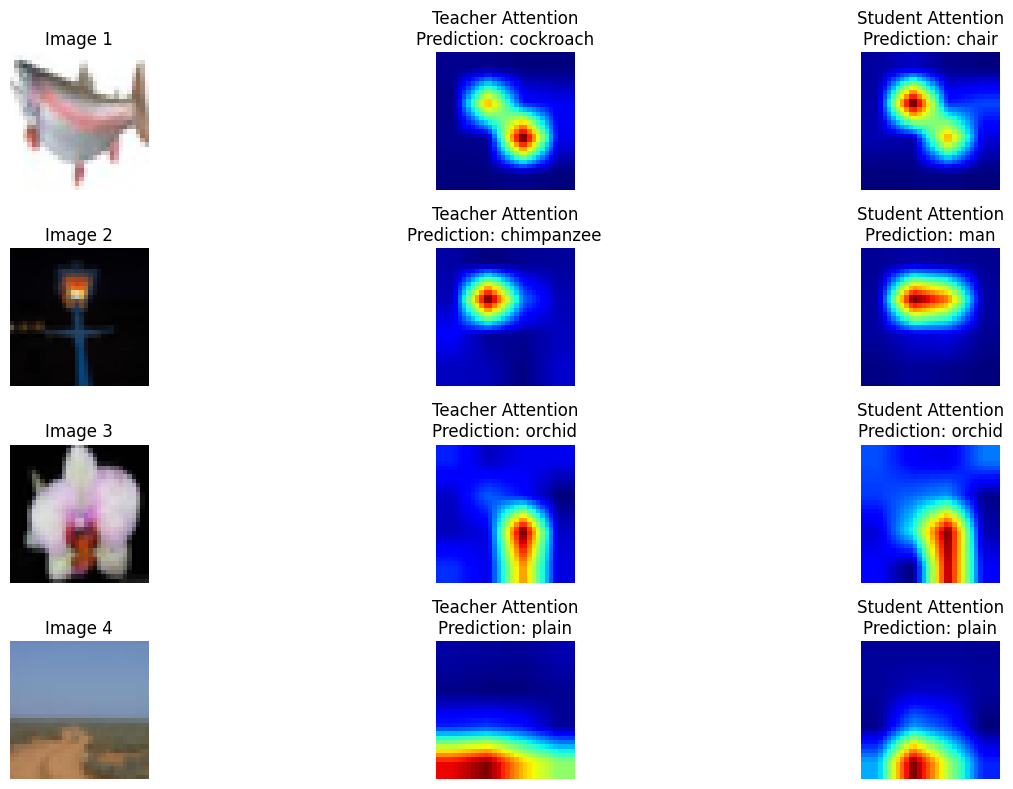

In [ ]:
NonTS_visualize_attention(teacher_model, student_model, output=None, device=device)